**Author:** Neven Caplar and the LINCC Frameworks team \
**Last updated:** January 29, 2025

# Demo: HATS and LSDB

In this notebook we'll show how to:
- Load object and source catalogs (lazily)
- Perform crossmatching with existing `LSDB/HATS` catalogs
- Discuss the performance
- Save the results of a science workflow to disk

There is also an "Extra topics" section with details on margin caches.

In [1]:
#!pip install -q -r requirements.txt

In [29]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
import warnings

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hats.io.file_io import read_parquet_metadata
from hats.inspection import plot_density

# Jupyter-specific settings and magic commands
%matplotlib inline

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2
os.environ["NUMEXPR_MAX_THREADS"] = "64"  # Set to the maximum number of threads you want to allow
os.environ["NUMEXPR_NUM_THREADS"] = "8"   # Set to the number of threads to actually use
dask.config.set({"dataframe.convert-string": False})
warnings.simplefilter("ignore", DeprecationWarning)

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.4.5.dev12+g93c26b7


We have numerous public catalogs available through [`data.lsdb.io`](https://data.lsdb.io).

In [30]:
catalogs_dir = "https://data.lsdb.io/hats"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf_dr14/ztf_object"
ztf_source_path = f"{catalogs_dir}/ztf_dr14/ztf_source"
ztf_object_margin_path = f"{catalogs_dir}/ztf_dr14/ztf_object_10arcs"

In [31]:
%%time

# Define a 1 degree cone region of interest
cone_search = ConeSearch(ra=10, dec=40, radius_arcsec=1*3600)

# Load lite version of Gaia DR3 (RA and DEC data only)
gaia_lite = lsdb.read_hats(gaia_path, columns=["ra", "dec"], search_filter=cone_search)

# Load all Gaia data for the cone
gaia = lsdb.read_hats(gaia_path, search_filter=cone_search)

CPU times: user 396 ms, sys: 26.4 ms, total: 422 ms
Wall time: 3.21 s


## Reading Parquet Metadata

HATS uses the Parquet file format to store catalogs. Parquet is a binary columnar data format, which means that information is efficiently encoded and compressed in binary format on disk, and is stored column wise in a way which allows efficiently loading only a subset of the columns. With each column, Parquet stores the column's metadata, including the column's name and data type.

Parquet also supports large datasets being partitioned into multiple files that are easier to work with individually. With a partitioned dataset, like HATS uses, there are metadata files at the root folder containing the partitioned files that store the combined and common metadata of each of the individual partition files metadata. Here, we can read this `_common_metadata` which includes the schema of the dataset, consisting of the column metadata for all the columns in the dataset.

In [32]:
list(read_parquet_metadata(os.path.join(gaia_path+'/dataset', "_common_metadata")).schema)[:2]

[<ParquetColumnSchema>
   name: _healpix_29
   path: _healpix_29
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE,
 <ParquetColumnSchema>
   name: solution_id
   path: solution_id
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE]

## Lazy Operations

When working with large datasets, there is too much data to be loaded into memory at once. To get around this, LSDB uses the HATS format which partitions a catalog into HEALPix cells and works on one partition at a time. This also allows the computation to be parallelized to work on multiple partitions at once. In order to efficiently carry out pipelines of operations though, it's better to batch operations so that multiple operations can be done back to back on the same partition instead of having to load and save each partition from storage after every operation.

For this reason, operations in LSDB are performed 'lazily'. This means when a catalog is read using `read_hats`, the actual catalog data isn't being read from storage. Instead, it only loads the metadata such as the column schema and the HEALPix structure of the partitions. When an operation like `cone_search` is called on a catalog, the data is not actually loaded and operated on when the line of code is executed. Instead, the catalog keeps track of the operations that it needs to perform so the entire pipeline can be efficiently run later. This also allows us to optimize the pipeline by only loading the partitions that are necessary. For example when performing a cone search like we do here, we only need the partitions that have data within the cone.

![lazy loading diagram](https://raw.githubusercontent.com/astronomy-commons/lsdb/main/docs/_static/lazy_diagram.svg)

So when we look at a catalog that has been lazy loaded we see the DataFrame without the data, just the columns and the number of partitions (including the HATS index of each partition encoding which HEALPix cell the partition is in). 

In [33]:
gaia_lite

,ra,dec
npartitions=2,,
"Order: 3, Pixel: 40",double[pyarrow],double[pyarrow]
"Order: 3, Pixel: 42",...,...


To load the data and perform the operations, call `compute()` which will load the necessary data and perform all the operations that have been called, and return a Pandas DataFrame with the results.

In [34]:
gaia_lite_computed = gaia_lite.compute()

The Figure belows shows the simple graph that DASK makes to ''compute'' this operation.

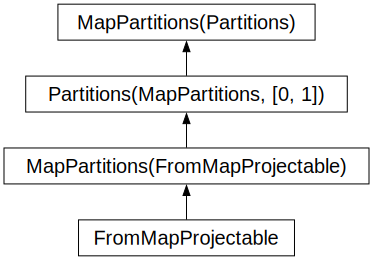

In [35]:
gaia_lite._ddf.visualize()

In [36]:
gaia_lite_computed

,ra,dec
_healpix_29,,
184207504728278031,10.150801,39.01399
184207572814040788,10.192082,39.013598
184207607326231973,10.228809,39.025354
184207611955708003,10.206771,39.01475
184207623303770224,10.209035,39.026308
...,...,...
190602610304590598,9.341324,40.848365
190602614772072368,9.345416,40.855759
190602627009691713,9.354055,40.859626


## HATS (Hierarchal Adaptive Tiling Scheme) Partitioning

To make it easier and more efficient to perform operations in parallel, HATS partitions contain roughly the same number of rows. This is done by using different HEALPix pixel sizes for different parts of the sky depending on the density of sources. This means catalogs with more rows will have smaller pixels for each partition, and so will have more partitions overall. We can see this below with the ZTF object and source catalogs, where the source catalog with many more data points has more partitions to keep the size of each partition consistent.

In [37]:
%%time
ztf_object = lsdb.read_hats(ztf_object_path, columns=["ra", "dec"]) # ZTF Object
ztf_source = lsdb.read_hats(ztf_source_path, columns=["ra", "dec"]) # ZTF Source

CPU times: user 3.54 s, sys: 74.7 ms, total: 3.61 s
Wall time: 5.52 s


In [38]:
ztf_object

,ra,dec
npartitions=2352,,
"Order: 3, Pixel: 0",double[pyarrow],double[pyarrow]
"Order: 3, Pixel: 1",...,...
...,...,...
"Order: 4, Pixel: 3070",...,...
"Order: 4, Pixel: 3071",...,...


In [39]:
ztf_source

,ra,dec
npartitions=41679,,
"Order: 4, Pixel: 0",double[pyarrow],double[pyarrow]
"Order: 4, Pixel: 1",...,...
...,...,...
"Order: 5, Pixel: 12286",...,...
"Order: 5, Pixel: 12287",...,...


In [40]:
# Define the center of the field of view
# For example: Right Ascension (RA) = 10 degrees, Declination (Dec) = 40 degrees
center = SkyCoord(ra=10*u.deg, dec=40*u.deg, frame='icrs')

# Define the field of view extent
# For example, using a radius of 1 degree
fov_radius = Angle(1, unit=u.deg)

We can see this difference in partition pixel sizes by plotting the HEALPix pixels of the partitions in the catalogs.

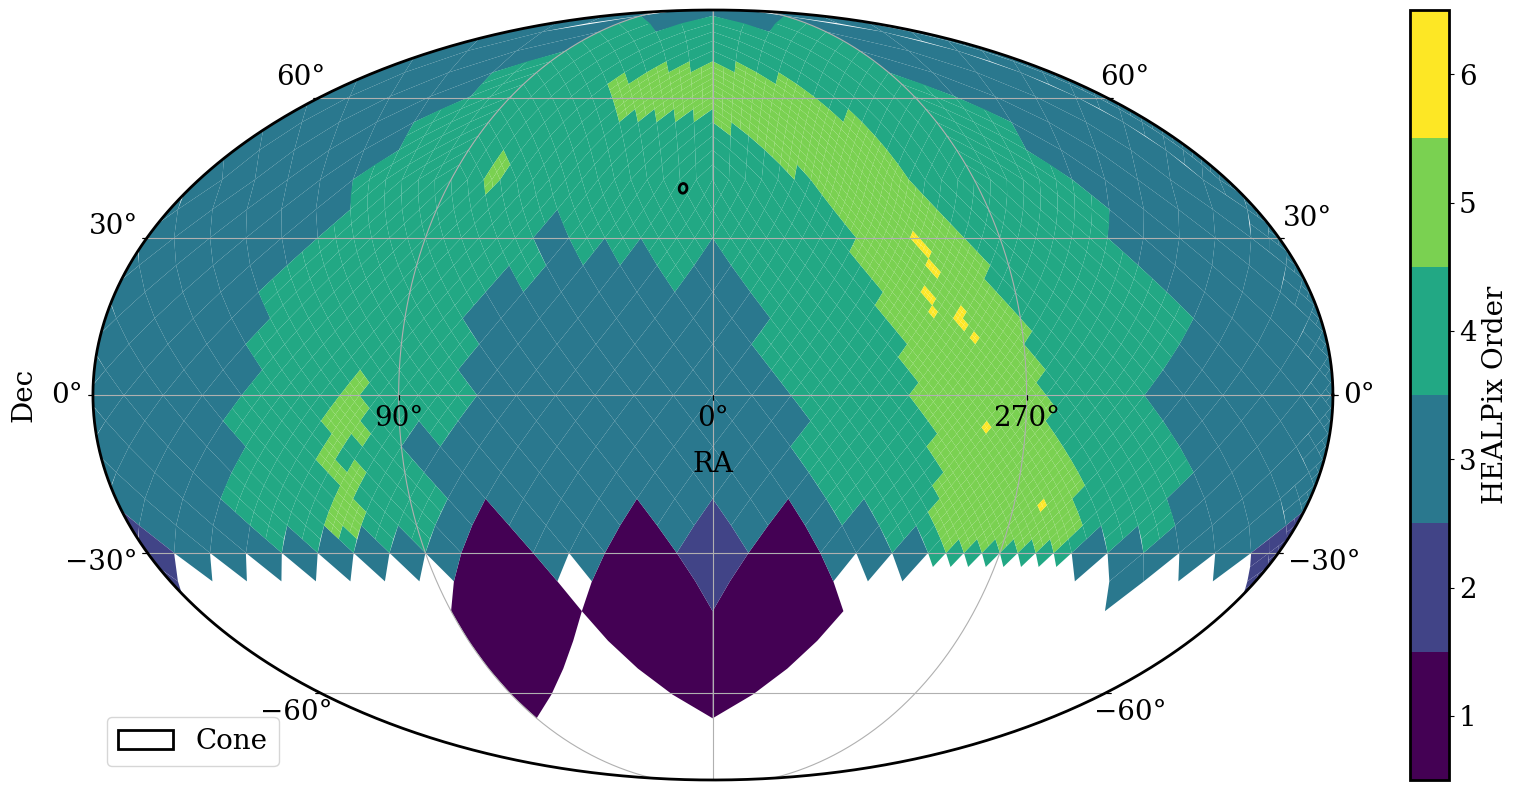

In [41]:
# Plot the pixel density map for ZTF object
fig = plt.figure(figsize=(20, 10))
_, ax = ztf_object.plot_pixels(fig=fig)
cone_search.plot(edgecolor="black",
    facecolor="none",label="Cone", linewidth=2)
plt.legend(loc="lower left")

/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


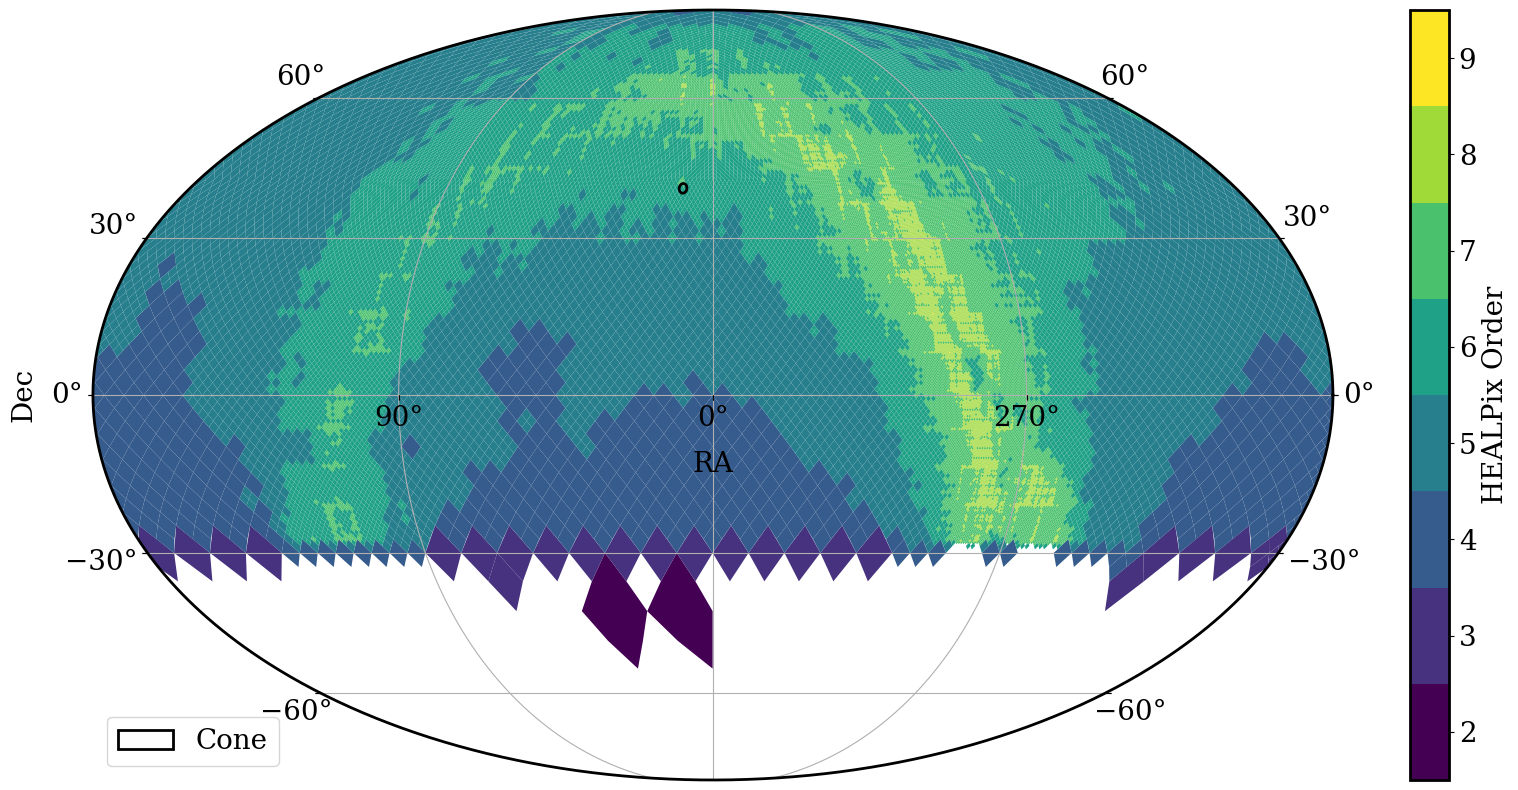

In [42]:
# Plot the pixel density map for ZTF sources
fig2 = plt.figure(figsize=(20, 10))
_, ax = ztf_source.plot_pixels(fig=fig2)
cone_search.plot(edgecolor="black",
    facecolor="none",label="Cone", linewidth=2)
plt.legend(loc="lower left")

If we zoom into the cone region we can observe the density of the ZTF HEALPix pixels in the region of interest.

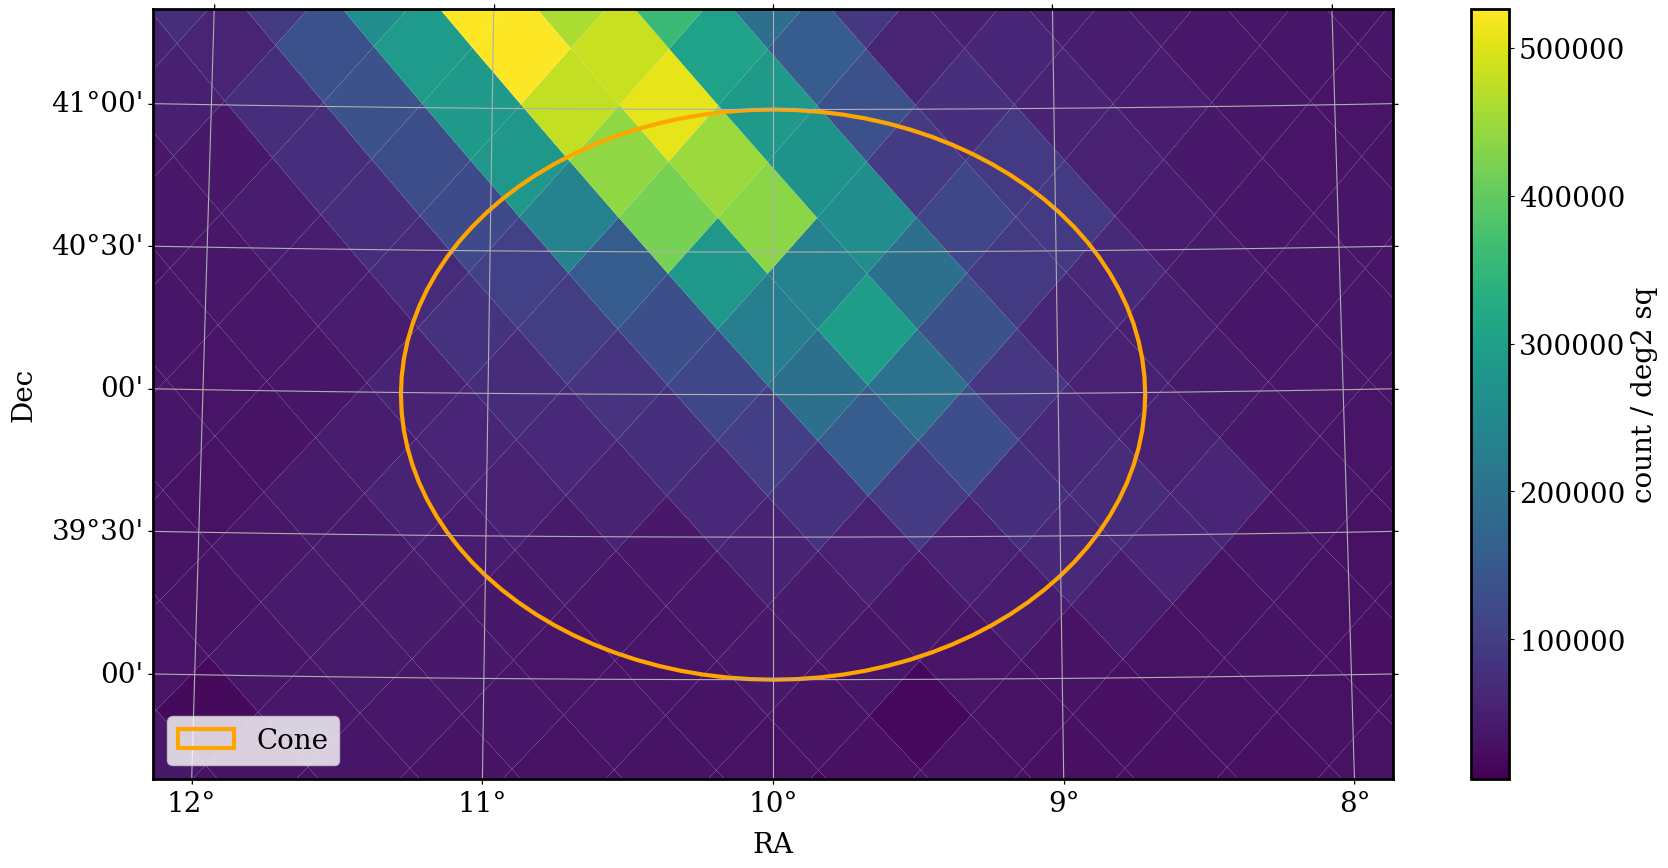

In [16]:
# Observe the point density map in the cone region of interest
fig3 = plt.figure(figsize=(20, 10))
fov = (Angle(3, 'deg'), Angle(3, 'deg'))

plot_density(ztf_object.hc_structure, fig=fig3, center=center, fov=fov)

cone_search.plot(edgecolor="orange",
    facecolor="none",label="Cone", linewidth=3)

plt.legend(loc="lower left")

## Crossmatching

Let's crossmatch our Gaia region with ZTF.

In [17]:
gaia_lite

,ra,dec
npartitions=2,,
"Order: 3, Pixel: 40",double[pyarrow],double[pyarrow]
"Order: 3, Pixel: 42",...,...


In [18]:
ztf_object

,ra,dec
npartitions=2352,,
"Order: 3, Pixel: 0",double[pyarrow],double[pyarrow]
"Order: 3, Pixel: 1",...,...
...,...,...
"Order: 4, Pixel: 3070",...,...
"Order: 4, Pixel: 3071",...,...


In [19]:
%time
xmatch_object = gaia_lite.crossmatch(ztf_object)

CPU times: user 10 μs, sys: 1 μs, total: 11 μs
Wall time: 24.6 μs


/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


### Crossmatching

Catalogs have valuable metadata about their partitioning structure (e.g. the sky coverage and the order of the pixels at each point in the sky). LSDB takes advantage of this information for operations like joining/crossmatching to identify pairs of partitions that are spatially close to each other in the sky. Each core available to your distributed Dask client will process a pair of partitions at a time.

![Crossmatch diagram](https://raw.githubusercontent.com/lincc-frameworks/MWGaia-DN_Introductory_School/main/assets/crossmatch-diagram.jpg)



The benchmarking plot below demonstrates the performance of different methods forcross-matching using the nearest neighbor approach within 1 arcsecond. The LSDB approach (red lines) shows superior scalability as the number of cross-matched objects increases, particularly when leveraging parallel workers (e.g., 4, 16, and 64 workers). In comparison, traditional methods  become significantly slower as the dataset size grows. Additionally LSDB can also work on datasets that exceed the memory limits of the machine.

![Crossmatch diagram](https://raw.githubusercontent.com/lincc-frameworks/LSDB-HATS-Midpoint-Review/main/assets/crossmatching-performance.png)

## The `head` method

For large operations we might want to see a small subset of the computed final data without doing the full computation. Like pandas, we can use the `head` operation to compute the first n rows of the final dataframe without computing the whole dataset.

In [20]:
xmatch_object.head(5)

,ra_gaia,dec_gaia,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
_healpix_29,,,,,
184207504728278031,10.150801,39.01399,10.150791,39.014008,0.068211
184207572814040788,10.192082,39.013598,10.192074,39.013617,0.072877
184207607326231973,10.228809,39.025354,10.228826,39.025369,0.073962
184207611955708003,10.206771,39.01475,10.206804,39.014813,0.24516
184207623303770224,10.209035,39.026308,10.209037,39.026328,0.070729


Here we load the ZTF object catalog again, this time with all the columns that we'll need to perform the analysis later. 

Note the previous warning about margin caches. Margins allow you to crossmatch objects which might be just across the border, in the neighboring pixels, which you might miss if you only search among the objects in a given pixel. We'll also be specifying the margin for ZTF.

In [21]:
%%time
# load ZTF with all columns and specify the margin cache!
ztf_object_full = lsdb.read_hats(ztf_object_path, margin_cache=ztf_object_margin_path)

CPU times: user 600 ms, sys: 8.15 ms, total: 608 ms
Wall time: 1.79 s


In [22]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf_object_full).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

CPU times: user 3.79 s, sys: 37.9 ms, total: 3.83 s
Wall time: 3.85 s


In [23]:
%%time
total = _all_sky_object.compute()

CPU times: user 8.57 s, sys: 1.59 s, total: 10.2 s
Wall time: 13.1 s


In [24]:
# this is the dataframe with all the computed objects
total

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,
184207572814040788,1636148068921376768,Gaia DR3 368415117761531008,368415117761531008,364350733,2016.0,10.192082,0.048873,39.013598,0.035497,0.354577,...,809,1028,65,16.972315,16.602573,16.500054,4,0.0,163.0,0.072877
184218532672042325,1636148068921376768,Gaia DR3 368437039274606720,368437039274606720,931023131,2016.0,10.466607,0.056526,39.09395,0.040134,0.344087,...,811,1027,65,17.266407,16.780576,16.654346,4,0.0,163.0,0.070706
184219124753298337,1636148068921376768,Gaia DR3 368438237570662656,368438237570662656,55475994,2016.0,10.355987,0.055996,39.053149,0.037111,0.343271,...,809,1028,65,16.967675,16.559287,16.437961,4,0.0,163.0,0.072884
184219545400595487,1636148068921376768,Gaia DR3 368439066499167616,368439066499167616,116974706,2016.0,10.244234,0.049744,39.083042,0.035786,0.586023,...,809,1028,65,16.79987,16.287623,16.139869,4,0.0,163.0,0.07563
184219747688048906,1636148068921376768,Gaia DR3 368439478816026496,368439478816026496,1654025075,2016.0,10.257254,0.045303,39.102251,0.028143,0.468521,...,811,1028,65,16.573539,16.146414,16.025162,4,0.0,163.0,0.037794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190597464442349834,1636148068921376768,Gaia DR3 381194913211659008,381194913211659008,1755949638,2016.0,9.512716,0.039739,40.902818,0.037382,0.453616,...,85,93,0,16.68388,16.196743,<NA>,4,0.0,169.0,0.037929
190598862117450624,1636148068921376768,Gaia DR3 381197696350465920,381197696350465920,640800788,2016.0,9.610301,0.029092,40.924382,0.026037,0.697723,...,795,1015,66,16.458721,15.919377,15.783977,4,0.0,169.0,0.041869
190598904346973641,1636148068921376768,Gaia DR3 381197795133047552,381197795133047552,1390989745,2016.0,9.628732,0.03343,40.927501,0.029875,0.538445,...,795,1016,65,16.479133,16.031485,15.912716,4,0.0,169.0,0.030181


Let us now visualize the GAIA object that got matched and the all of the starting GAIA matches. The red circle shows the cone in which we conducted the cross-match. 

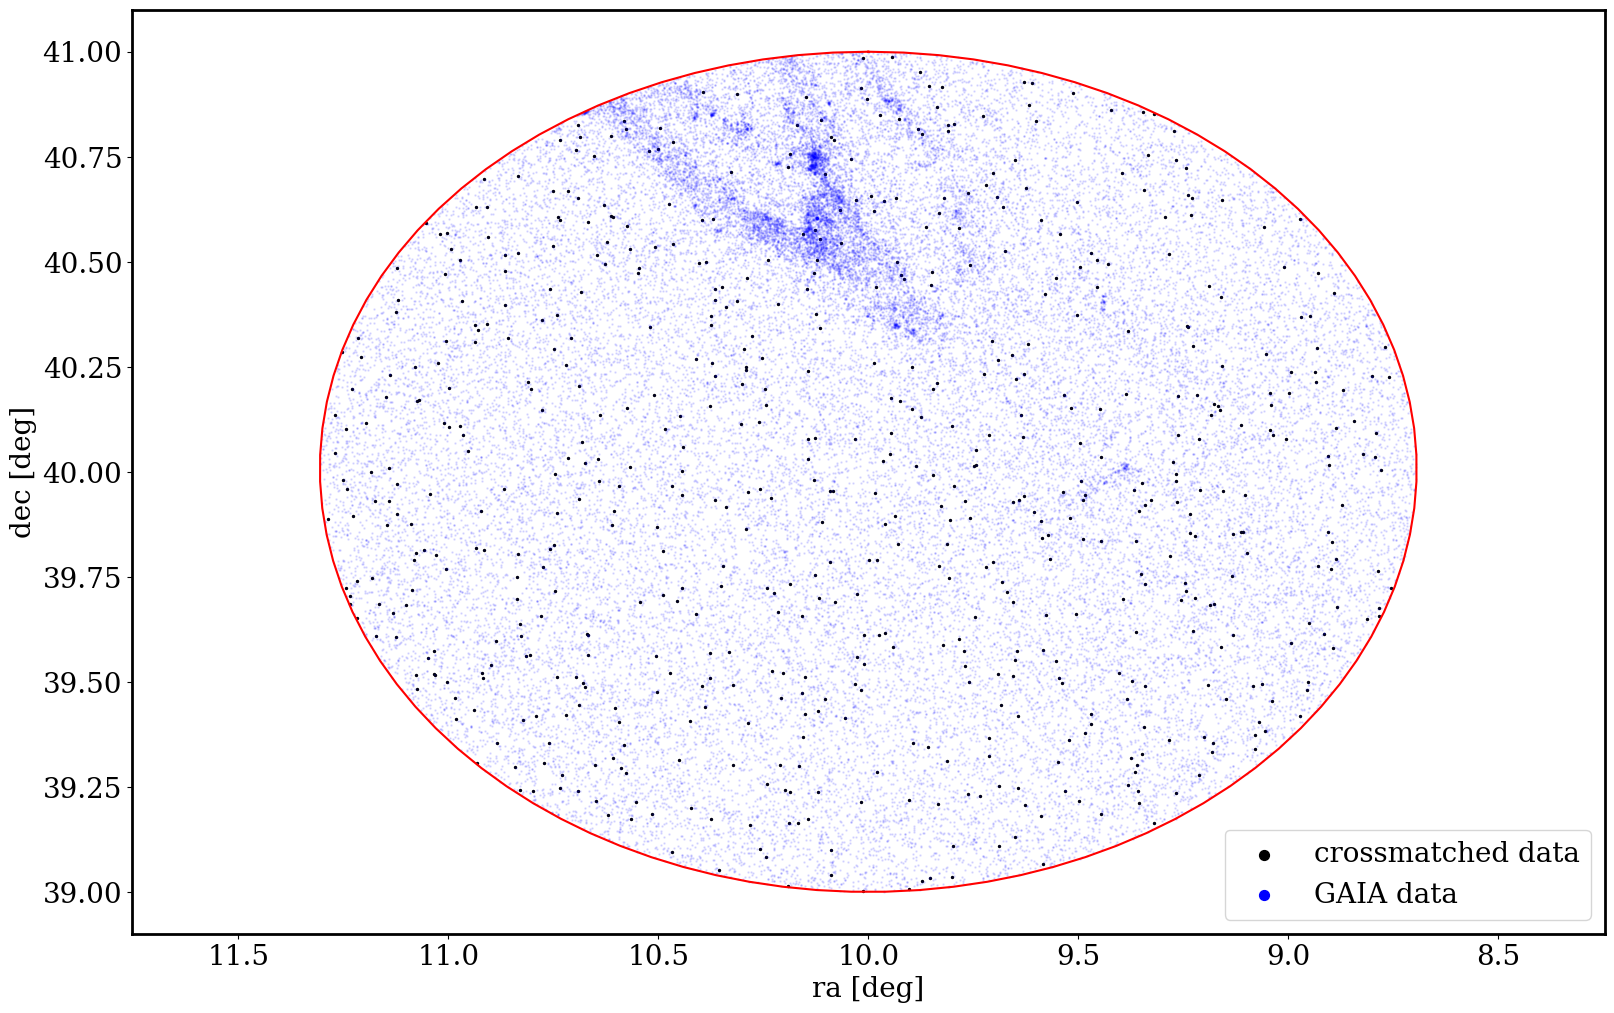

In [25]:
plt.figure(figsize=(19, 12))

# Main scatter plots
plt.scatter(total['ra_gaia'].values, total['dec_gaia'].values, color='black', s=2)
plt.scatter(gaia_lite_computed['ra'], gaia_lite_computed['dec'], color='blue', s=0.8, alpha=0.1)

# Add dummy scatter points for the legend with the same size
plt.scatter([], [], color='black', s=50, label='crossmatched data')  # Adjusted black dot size
plt.scatter([], [], color='blue', s=50, label='GAIA data')  # Ensure blue dot size remains prominent

# Plot a circle around the center
circle_coord = center.directional_offset_by(position_angle=np.linspace(0, 360, 100) * u.deg, separation=1 * u.deg)
plt.plot(circle_coord.ra.deg, circle_coord.dec.deg, color='red')

# Adjust the x-axis direction
plt.gca().invert_xaxis()

plt.axis('equal')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.legend(loc='lower right')
plt.show()

## Export catalogs to disk

Once the analysis is complete we can export our results in the HATS format. To do so you would uncomment the line below. You need to provide a base directory path for your catalog and you should also provide a catalog name that expresses the nature of your data. You can load the saved catalog back via LSDB, or you can load the parquet files that are saved to disk with any other parquet reader of your choice.

In [26]:
# export crossmatched data to disk
# _all_sky_object.to_hats(base_catalog_path="ztf_x_gaia", catalog_name="ztf_x_gaia")

## Extra topics

### Margin caches

Remember the **warning** about the missing margin cache?

```
RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
```

Margins are catalogs that specify what objects, for each pixel, are within a certain distance of their borders. They allows us to crossmatch objects which might be just across the border, in the neighboring pixels, which you might miss if you only search among the objects in a given pixel. 

In the image below we are trying to obtain the matches for the points in the "green" pixel. The closest match for the selected green object is in a different pixel. The closest green neighbor to this object is not even within the specified crossmatching radius (seen in dark green). This means that, without margin caches, this green object would simply not have a match, which is inaccurate!

![Margin cache diagram](https://lsdb.readthedocs.io/en/stable/_images/pixel-boundary-example.png)

Notice that your crossmatching distance, `radius_arcsec`, should not be larger than your margin cache radius. You can usually infer the margin cache radius from the catalog name, or look for it programatically.

In [27]:
ztf_object_full.margin.hc_structure.catalog_info.margin_threshold

10.0